In [8]:
import jsbsim
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os

FileNotFoundError: [Errno 2] No such file or directory: '../../aircraft/global5000/global5000.xml'

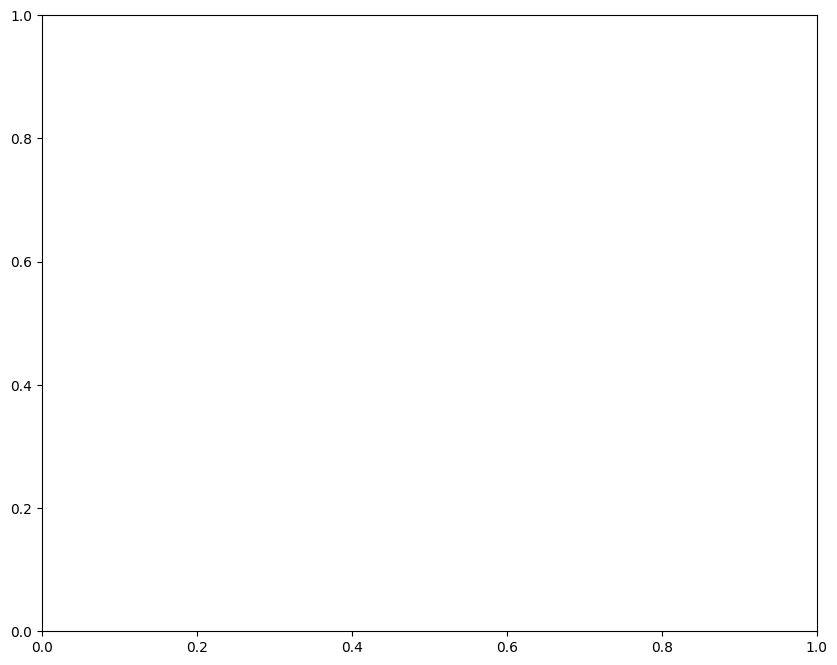

In [10]:
# Global variables that must be modified to match your particular need
# The aircraft name
# Note - It should match the exact spelling of the model file
AIRCRAFT_NAME="global5000"
# Relative path to the directory where the flight model is stored
# Note - Aircraft directory needs to be writeable in order to modify the cg
PATH_TO_JSBSIM_FILES="../.."

# Avoid flooding the console with log messages
jsbsim.FGJSBBase().debug_lvl = 0

# Function to change CG in aircraft xml
# Change the directory to the aircraft to be studied
# Note - Moments of inertia are not updated
def changeCG(fdm, cgPos, readOnly):
    tree = ET.parse(os.path.join(fdm.get_root_dir(), f'aircraft/{AIRCRAFT_NAME}/{AIRCRAFT_NAME}.xml'))
    root = tree.getroot()

    for x in root.findall('mass_balance/location'):
        cg = x.find('x').text
        if not readOnly:
             x.find('x').text=str(cgPos)
             tree.write(os.path.join(fdm.get_root_dir(), f'aircraft/{AIRCRAFT_NAME}/{AIRCRAFT_NAME}.xml'))
    return cg

# Fuel max for Global5000
fuelmax=8097.63

# Prepare subplots to overlay plots
fig, ax = plt.subplots(figsize=(10,8))

# Define here the payloads to be studied
payload=[1500,15172/2,15172]
# Define here the mass of fuel
fuel=[1000,fuelmax/2,fuelmax]
# Three cases for weight
weight=["light","mid","heavy"]

fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)
# Get the original CG from aircraft xml
cgOrig=float(changeCG(fdm,0,True))
# Vary CG in the study
cgPos=[cgOrig*0.95,cgOrig*1.05]

# Vary altitude
h_ft=[8000,30000]

# Run the simulation varying CG, altitude, speed and total weight

# Run for different CG's
for j in range(2):
    fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)
    fdm.load_model(f'{AIRCRAFT_NAME}')
    # Set engines running
    cg=changeCG(fdm,cgPos[j],False)
    fdm['propulsion/engine[0]/set-running'] = 1
    fdm['propulsion/engine[1]/set-running'] = 1

    # Run for different weights
    for i in range(3):
        results = []

        # Run for different speeds
        for speed in range(90, 550, 10):
            fdm['ic/h-sl-ft'] = h_ft[j]
            fdm['ic/vc-kts'] = speed
            fdm['ic/gamma-deg'] = 0
            fdm['propulsion/tank[0]/contents-lbs'] = fuel[i]
            fdm['propulsion/tank[1]/contents-lbs'] = fuel[i]
            fdm['propulsion/tank[2]/contents-lbs'] = fuel[i]
            fdm['inertia/pointmass-weight-lbs[0]'] = payload[i]

            # Initialize the aircraft with initial conditions
            fdm.run_ic()
            # Run fdm model
            fdm.run()

            # Trim
            try:
                fdm['simulation/do_simple_trim'] = 1
                results.append((fdm['velocities/vc-kts'], fdm['aero/alpha-deg']))
            except jsbsim.TrimFailureError:
                pass  # Ignore trim failure exceptions

        print("-----------------------------------------")
        print("Altitude {} - Weight {} - CG {}".format(h_ft[j],weight[i],cgPos[j]))
        print("-----------------------------------------")
        for result in results:
            print(result[0], result[1])

        speed, alpha = zip(*results)
        ax.plot(speed, alpha,label="{0} weight {1:.0f} kft {2:.2f} % cg".format(weight[i],h_ft[j]/1000,(float(cgPos[j])/float(cgOrig)-1)*100))

# Restore original CG for the aircraft xml
cgx=changeCG(fdm," {:.2f} ".format(cgOrig),False)

# Plot final results
ax.legend(frameon=False)
ax.set_xlabel('KCAS (kt)')
ax.set_ylabel('AoA (deg)')
ax.set_title('AoA vs KCAS')

plt.show()